# AIPI 590 - XAI | Assignment #02
### Adversarial Attacks (Adversarial Patches)
### Yabei Zeng

#### Link to Github: https://colab.research.google.com/github/yabeizeng1121/XAI/blob/main/Assignment2/Adversarial_Patch_Assignment.ipynb

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yabeizeng1121/XAI/blob/main/Assignment2/Adversarial_Patch_Assignment.ipynb)


In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/yabeizeng1121/XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment2'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'XAI'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 104.53 KiB | 14.93 MiB/s, done.
/content/XAI/Assignment2
fountain.jpg  imagenet_classes.txt  requirements.txt


## Import Libraries

Load all necessary libraries required for the adversarial patch creation and model manipulation.


In [2]:
# Load libraries for image processing and model handling
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet34, ResNet34_Weights


## Model Preparation

Initialize and prepare the ResNet34 model for testing our adversarial patch.


In [3]:
# Function to load and prepare the ResNet34 model
def get_pretrained_resnet():
    model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    model.eval()
    return model

# Load the model
model = get_pretrained_resnet()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 45.2MB/s]


## Adversarial Patch Design

In the Adversarial Patch Design, I choose to implement a `fountain` patch, I will utilizes a pixelation effect to subtly introduce distortions into the fountain's image. This approach involves creating a mosaic effect that simplifies the details of the fountain into larger, block-like segments, making it harder for the model to accurately identify and classify the fountain based on its usual features.

The pixelation is applied strategically to blend with the natural textures and colors of the fountain and its surrounding environment. By adjusting the size of the mosaic blocks and their colors, the patch integrates seamlessly into the scene, ensuring it does not stand out conspicuously to human observers. This adjustment aims to maintain the visual integrity of the image while still introducing enough anomaly to disrupt the AI’s usual pattern recognition capabilities.


In [4]:
# Function to pixelate the image
def pixelate(image, pixel_size):
    """
    Pixelate the image to create a mosaic effect by resizing down and then back up.
    :param image: PIL Image to be pixelated.
    :param pixel_size: Size of each 'pixel' in the mosaic.
    :return: Pixelated PIL Image.
    """
    # Resize down using nearest neighbor to create the mosaic effect
    small_image = image.resize(
        (image.width // pixel_size, image.height // pixel_size),
        resample=Image.NEAREST
    )
    # Resize back up
    return small_image.resize(
        (image.width, image.height),
        resample=Image.NEAREST
    )

# Function to prepare the image tensor for model prediction
def prepare_image(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Function to get model prediction
def get_model_prediction(image_tensor):
    # Load the pre-trained ResNet34 model using the correct weights
    model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    model.eval()

    # Predict the class of the image using the model
    with torch.no_grad():
        outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    return predicted.item()

def load_imagenet_classes(file_path):
    with open(file_path, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


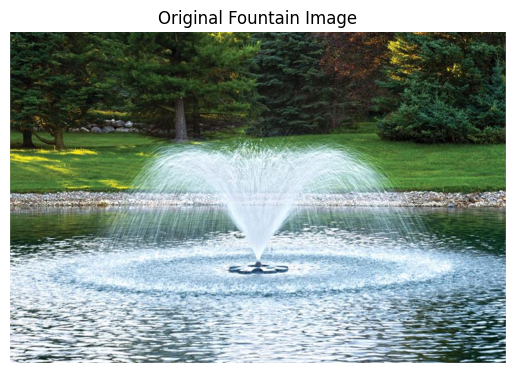

Predicted class index: fountain


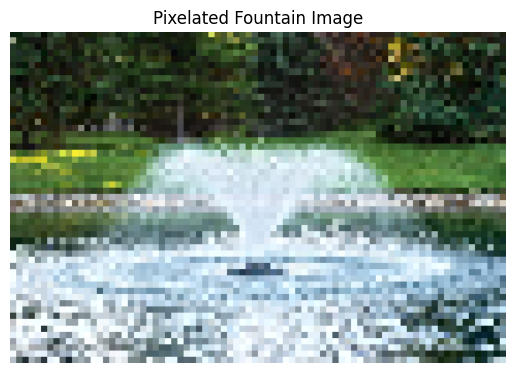

Predicted class index: white wolf


In [5]:
def main():
    # load the patch classes
    imagenet_classes = load_imagenet_classes('/content/XAI/Assignment2/imagenet_classes.txt')
    # Load the original image
    image_path = '/content/XAI/Assignment2/fountain.jpg'
    image = Image.open(image_path)

    # Display the original image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title("Original Fountain Image")
    plt.show()

    # Prepare the pixelated image for model prediction
    true_image_tensor = prepare_image(image)

    # Get and print the model prediction
    true_predicted_class = get_model_prediction(true_image_tensor)
    print("Predicted class index:", imagenet_classes[true_predicted_class])

    # Pixelate the image
    pixelated_image = pixelate(image, 10)  # Adjust '10' to change the pixelation level

    # Optionally, save the modified image to a file
    pixelated_image.save('modified_image.jpg')


    # Display the pixelated image
    plt.imshow(pixelated_image)
    plt.axis('off')
    plt.title("Pixelated Fountain Image")
    plt.show()

    # Prepare the pixelated image for model prediction
    image_tensor = prepare_image(pixelated_image)

    # Get and print the model prediction
    predicted_class = get_model_prediction(image_tensor)
    print("Predicted class index:", imagenet_classes[predicted_class])

if __name__ == "__main__":
    main()

## Results and Analysis

### Results

After applying pixelation and altering a specific pixel in the fountain image, the following predictions were observed:

- **Original Image**: The model classified the original fountain image as `fountain`.
- **Modified Image**: The pixelated and altered image was misclassified as `white wolf`, showing a shift in the model's prediction.

### Analysis

- **Pixelation Impact**: The mosaic effect likely caused the model to lose important details, leading to misclassification.
- **Model Vulnerability**: This demonstrates how minor visual changes can significantly alter the predictions of even advanced models like ResNet34, highlighting the model's sensitivity to adversarial perturbations.



## Reference
I took insights from this link:
https://www.geeksforgeeks.org/mastering-adversarial-attacks-how-one-pixel-can-fool-a-neural-network/

This link gave a tutorial of how a single pixel can affect AI's result, and I thought changing my image into pixels to create mosaic effect will also affect the AI's evaluation.